In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] =""
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline

C:\Users\mudda\anaconda3\envs\tf_gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
nepochs=10
im_height, im_width = 224, 224  ## Image input resolution

In [5]:
### datagenerator to get the batch of data, It takes file list, batch size and resolution as arguments
from tensorflow.keras import layers

class BrainTumorDataset(tf.keras.utils.Sequence):
    def __init__(self, df,
                 batch_size,
                 input_size=(224, 224, 3),
                 shuffle=True, do_augmentation=False):
        
        self.df = df
        self.batch_size=batch_size
        self.input_size=input_size
        self.do_augmentation=do_augmentation
        if do_augmentation:  ## We need to augment only the training data here.
            self.data_augmentation = tf.keras.Sequential([
                layers.RandomFlip("horizontal"),
                layers.RandomRotation(0.2),
                ])

            self.replicate_factor=12
        else:
            self.replicate_factor=1

        self.max_index=len(self.df)//self.batch_size
    
    def on_epoch_end(self):
        pass
    
    def load_image(self,name):
        image= tf.keras.preprocessing.image.load_img(name)
        image= tf.keras.preprocessing.image.img_to_array(image)
        image= tf.image.resize(image,(self.input_size[0],self.input_size[1]))
        if self.do_augmentation: # and np.random.rand(1)<0.2:   #0.2 propbality the augmentation happens, we don't want distort all the imagews
            image=self.data_augmentation(image)
        return image

    def __getitem__(self, index):
        index=index%self.max_index
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        images=[]
        labels=[]
        for index, row in batches.iterrows():
          images.append(self.load_image(row['filename']))
          labels.append(row['labels'])
        return np.array(images),np.array(labels)
    
    def __len__(self):
        return len(self.df)*self.replicate_factor // self.batch_size

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
###### Function to Get the Model

def GetModel(type='simple',im_height=224,im_width=224, compile=True):
    tf.keras.backend.reset_uids()
    if type=='simple':
        model = Sequential([
          layers.Rescaling(1./255, input_shape=(im_height, im_width, 3)),
          layers.Conv2D(8, 3, padding='valid', activation='relu',name='cnn1'),
          layers.MaxPooling2D(),
          layers.Conv2D(16, 3, padding='valid', activation='relu',name='cnn2'),
          layers.MaxPooling2D(),
          layers.Conv2D(32, 3, padding='valid', activation='relu',name='cnn3'),
          layers.MaxPooling2D(),
          layers.Flatten(),
          layers.Dense(32, activation='relu',name='dense1'),
          layers.Dense(1,name='dense2')
        ])
    elif type=='extra_dense_cnn':
        model = Sequential([
          layers.Rescaling(1./255, input_shape=(im_height, im_width, 3)),
          layers.Conv2D(8, 3, padding='valid', activation='relu',name='cnn1',trainable=False),
          layers.MaxPooling2D(),
          layers.Conv2D(16, 3, padding='valid', activation='relu',name='cnn2',trainable=False),
          layers.MaxPooling2D(),
          layers.Conv2D(32, 3, padding='valid', activation='relu',name='cnn3',trainable=False),
          layers.MaxPooling2D(),
          layers.Conv2D(32, 3, padding='same', activation='relu',name='cnn4',trainable=True),
          layers.Flatten(),
          layers.Dense(32, activation='relu',name='dense1'),
          layers.Dense(32, activation='relu',name='dense_post'),
          layers.Dense(1,name='dense2')
        ])
    else:
      raise 'Model type is not correct'
    if compile:
      model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
    model.summary()
    return model
# model_1=GetModel()
# for layer in model_1.layers:
#   print(layer.name)


In [7]:

model=GetModel(type='extra_dense_cnn')
base_model=GetModel(type='simple')
base_model.load_weights('./checkpoints/main_model/model')
base_layer_names = [layer.name for layer in base_model.layers]

### Load the weights by name
for layer in model.layers:
    if layer.name in base_layer_names:
        layer.set_weights(base_model.get_layer(layer.name).get_weights())

df=pd.read_csv('./brain_tumour_dataset/rasp1_data.csv') 
train_rasp1,vals_rasp1=train_test_split(df,train_size=0.9, stratify=df['labels'],random_state=19)

train_ds= BrainTumorDataset(train_rasp1,8,input_size=(im_height, im_width,3),do_augmentation=False)
val_ds =  BrainTumorDataset(vals_rasp1,1,input_size=(im_height, im_width,3))
history = model.fit(train_ds,validation_data=val_ds,epochs=nepochs) ## Train and save the rasp1 model

model.save_weights('./checkpoints/rasp1_model/model')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 cnn1 (Conv2D)               (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 cnn2 (Conv2D)               (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 cnn3 (Conv2D)               (None, 52, 52, 32)        4

In [8]:
loss_rasp1, accuracy_rasp1=model.evaluate(val_ds,batch_size=1)
print(f'Accuracy of rasberrypi--1 trained model on unseen data {accuracy_rasp1*100}%')

10/10 [==============================] - 0s 9ms/step - loss: 0.2947 - accuracy: 0.9000
Accuracy of rasberrypi--1 trained model on unseen data 89.99999761581421%


In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
os.mkdir('./checkpoints/rasp1_model_tflite/');
# Save the model.
with open('./checkpoints/rasp1_model_tflite/model_rasp1.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\mudda\AppData\Local\Temp\tmp1yx4pygg\assets


FileExistsError: [WinError 183] Cannot create a file when that file already exists: './checkpoints/rasp1_model_tflite/'

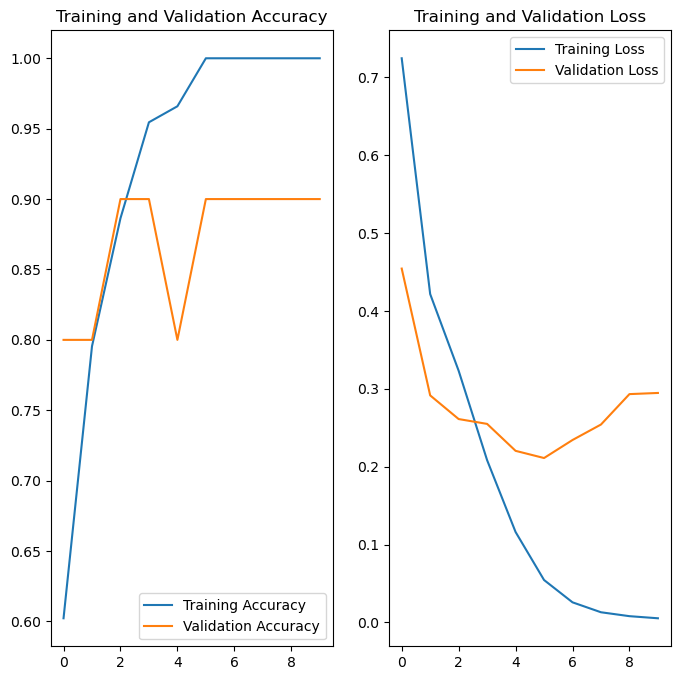

In [10]:
#Plot the train/val losses and accuracies over the course of training.
#Took from https://www.tensorflow.org/tutorials/images/classification
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(nepochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
